## calculate climatological flux correction

In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import os

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

Text(0.5, 1.0, 'global avg mean wfo diff, monthly \n (yearly mean v small: 2.3778268618516067e-08 kg/m2/s)')

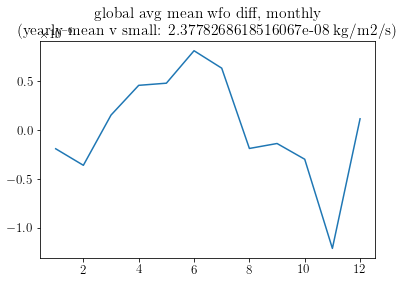

In [2]:
view = True
if view:

    tvar = 'wfo'
    KDD0 = xr.open_dataset(f'./data/KDD0_{tvar}.nc')
    KWD0 = xr.open_dataset(f'./data/KWD0_{tvar}.nc')


#     KDD0['time_counter'] = KDD0.indexes['time_counter'].to_datetimeindex()
#     KWD0['time_counter'] = KWD0.indexes['time_counter'].to_datetimeindex()

    KWD0_clim = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
    KDD0_clim = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
    
  
tmask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/mesh_mask3_6.nc')

KWD = KWD0_clim.weighted(tmask.csize).mean(dim = ['y','x'])
KDD = KDD0_clim.weighted(tmask.csize).mean(dim = ['y','x'])


# print('climatological global empave diff is small')
# print(KDD.wfo.values-KWD.wfo.values)

KWD0_40y = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")
KDD0_40y = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")

diff_D = KDD0_40y - KWD0_40y

mean_ts = diff_D.weighted(tmask.csize).mean(dim = ['y','x'])

plt.plot(np.arange(1,13), mean_ts.wfo.values)
plt.title('global avg mean wfo diff, monthly \n (yearly mean v small: 2.3778268618516067e-08 kg/m2/s)')

## map of summer and winter EMPave

## create daily adjustments (at monthly resolution, nothing fancy)

In [3]:

diff_D = diff_D.rename({"month": "time"})
diff_clim = diff_D.wfo.values
print(np.shape(diff_clim))

#days of year
nlys = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335,365])
lys = np.array([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336,366])

lydiff = np.zeros([366,149,182])
nlydiff = np.zeros([365,149,182])

#corrector
for i in range(0,12):
    
    lydiff[lys[i]:lys[i+1],:,:] = diff_clim[i,:,:]
    nlydiff[nlys[i]:nlys[i+1],:,:] = diff_clim[i,:,:]
    

(12, 149, 182)


In [4]:
def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False


## produce the flux-corrected rain and snow field (global monthly, global monthly 2x, 5x, 10x)

### for 1920-1940, we use 1990- non leap year, needs to be dealt with differently

In [5]:

def make_and_symlink_flux_dirs(ndir, scal):

    os.makedirs(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}', exist_ok=True)
    print(f'scaling factor {scal}')
    print(f'directory in /gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}')
    print()

    for yr in range(1920,1940):
        
        if (yr%20 == 0): print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        w['prra'] = w['prra'] - nlydiff * scal
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}/era5_bulk_13_y{yr}.nc')
 
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        w['prsn'] = w['prsn'] - nlydiff * scal
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}/era5_bulk_14_y{yr}.nc')
        
    for yr in range(1940,2024):
        
        if (yr%20 == 0): print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global monthly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        if is_leap_year(yr): w['prra'] = w['prra'] - lydiff * scal
        else: w['prra'] = w['prra'] - nlydiff * scal
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}/era5_bulk_13_y{yr}.nc')
 
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        if is_leap_year(yr): w['prsn'] = w['prsn'] - lydiff * scal
        else: w['prsn'] = w['prsn'] - nlydiff * scal
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}/era5_bulk_14_y{yr}.nc')
        
    print('do the symlinking of non-rain things')
    for y in range(1920,2024):
        if (y%20 == 0): print(y)
        for b in range(8,16):
            if ((b != 13) & (b != 14)):
                try:
                    src = f'{odir}era5_bulk_{b}_y{y}.nc'
                    dst = f'{odir}/{ndir}/era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)

                    #print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
                    
        try:
            src = f'{odir}/taux_1d_y{y}.nc'
            dst = f'{odir}/{ndir}/taux_1d_y{y}.nc'
            os.symlink(src,dst)

        except:
            print(f'year {y} taux is off')
        try:
            src = f'{odir}/tauy_1d_y{y}.nc'
            dst = f'{odir}/{ndir}/tauy_1d_y{y}.nc'
            os.symlink(src,dst)

        except:
            print(f'year {y} tauy is off')

In [6]:
# make_and_symlink_flux_dirs('fc_glob3pt0', 3)
# make_and_symlink_flux_dirs('fc_glob4pt5', 4.5)
# make_and_symlink_flux_dirs('fc_glob4pt8', 4.8)
# make_and_symlink_flux_dirs('fc_glob5pt0', 5)
# make_and_symlink_flux_dirs('fc_glob5pt2', 5.2)
# make_and_symlink_flux_dirs('fc_glob5pt5', 5.5)
# make_and_symlink_flux_dirs('fc_glob7pt0', 7)

In [7]:

def make_and_symlink_1750_1920(ndir, scal):

    os.makedirs(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}', exist_ok=True)
    print(f'scaling factor {scal}')
    print(f'directory in /gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}')
    print()

    for yr in range(1750,1920):
        
        if (yr%20 == 0): print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        w['prra'] = w['prra'] - nlydiff * scal
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}/era5_bulk_13_y{yr}.nc')
 
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        w['prsn'] = w['prsn'] - nlydiff * scal
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/{ndir}/era5_bulk_14_y{yr}.nc')
        
       
    print('do the symlinking of non-rain things')
    for y in range(1750,1920):
        if (y%20 == 0): print(y)
        for b in range(8,16):
            if ((b != 13) & (b != 14)):
                try:
                    src = f'{odir}era5_bulk_{b}_y{y}.nc'
                    dst = f'{odir}/{ndir}/era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)

                    #print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
                    
        try:
            src = f'{odir}/taux_1d_y{y}.nc'
            dst = f'{odir}/{ndir}/taux_1d_y{y}.nc'
            os.symlink(src,dst)

        except:
            print(f'year {y} taux is off')
        try:
            src = f'{odir}/tauy_1d_y{y}.nc'
            dst = f'{odir}/{ndir}/tauy_1d_y{y}.nc'
            os.symlink(src,dst)

        except:
            print(f'year {y} tauy is off')

In [8]:
make_and_symlink_1750_1920('fc_glob5pt0', 5)

scaling factor 5
directory in /gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0

1760
1780
1800
1820
1840
1860
1880
1900
do the symlinking of non-rain things
1760
1780
1800
1820
1840
1860
1880
1900
